# Try gaussian regression on parameters of a synthetic data set

In [9]:
# Import packages
import numpy as np
import scipy.io as sio

# Import Gaussian-regression related functions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Pre-process the data
from sklearn import preprocessing

# Plot figure
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.ticker import LinearLocator
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [23]:
AA = [0.002, 0.006]
BB = [0.009, 0.013]

# Path to the shell file
path_to_shell_file = '/home/shengduo/pylith-developer/build/debug/pylith-nonRegSlipLawWithVaryingB/examples/bar_shearwave/quad4/RunJobsJP.sh'
shellRead = open(path_to_shell_file, 'r')
list_of_lines = shellRead.readlines()
shellRead.close()

list_of_lines[9] = "AA=" + str(tuple(AA)).replace(',', '') + "\n"
list_of_lines[10] = "BB=" + str(tuple(BB)).replace(',', '') + "\n"

shellWrite = open(path_to_shell_file, 'w')
shellWrite.writelines(list_of_lines)
shellWrite.close()


In [22]:
str(tuple(AA)).replace(',', '')

'(0.002 0.006)'

In [17]:
list_of_lines[9]

'AA=(0.003 0.007)\n'

In [11]:
!source /home/shengduo/pylith-developer/build/debug/pylith-nonRegSlipLawWithVaryingB/examples/bar_shearwave/quad4/RunJobsJP.sh

Running case A0.003_B0.009
Finished in 12 s!

Running case A0.007_B0.013
Finished in 12 s!

/home/shengduo/InverseProblems/GPRWorkingField


In [87]:
def GPRPredictor(train_path, test_path, test_idx = 0, si_eta = 0.1):
    # Load training data set
    loaded = sio.loadmat(train_path)
    U = loaded['Us']
    Y = loaded['observations']

    U_scaler = preprocessing.StandardScaler()
    U_scaler.fit(U)
    U_scaled = U_scaler.transform(U)

    Y_scaler = preprocessing.StandardScaler()
    Y_scaler.fit(Y)
    Y_scaled = Y_scaler.transform(Y)

    # Load testing data set
    loaded = sio.loadmat(test_path)
    U_test = loaded['Us']
    Y_test = loaded['observations']

    U_test_scaled = U_scaler.transform(U_test)
    Y_test_scaled = Y_scaler.transform(Y_test)
    
    # Train the gaussian_process
    kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gaussian_process.fit(U_scaled, Y_scaled)
    # gaussian_process.kernel_
    
    # Calculate U_plot
    minU = np.min(U, axis = 0)
    maxU = np.max(U, axis = 0)
    nOfGridPoints = 100

    xis = []
    for i in range(minU.shape[0]):
        xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

    # Generate grid and draw predictions
    UPlotGrid = np.meshgrid(xis[0], xis[1])
    UPlotGrid = np.stack(UPlotGrid, axis = 2)
    UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
    UPlotGridFat_scaled = U_scaler.transform(UPlotGridFat)
    YPlotGridFat_scaled = gaussian_process.predict(UPlotGridFat_scaled)
    YPlotGrid_scaled = YPlotGridFat_scaled.reshape([nOfGridPoints, nOfGridPoints, Y_scaled.shape[1]])
    
    # Test
    u = U_test_scaled[test_idx, :]
    y = Y_test_scaled[test_idx, :]

    # Compute \Phi(u) = \|y - G_N(u)\|^2
    PhiPlot_grid = np.linalg.norm(y - YPlotGrid_scaled, axis = 2) ** 2

    # Compute pdf(u) = exp(-\Phi(u))
    pdf_grid = np.exp(-PhiPlot_grid / si_eta)
    pdf_grid = pdf_grid / np.max(pdf_grid)

    # Plot figure
    from matplotlib import pyplot as plt
    from matplotlib import cm
    import matplotlib
    from matplotlib.ticker import LinearLocator
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'

    fig, ax = plt.subplots(1, 1, figsize = (7, 6), dpi = 100)

    cp = ax.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid)
    
    cbar = fig.colorbar(cp)
    ax.scatter(U[:, 0], U[:, 1], color='white')
    ax.set_xlabel('$u_1$', fontsize = 20)
    ax.set_ylabel('$u_2$', fontsize = 20)
    cbar.set_label('$\exp(-\\Phi(u))$', fontsize = 20)

    # Add a color bar which maps values to colors.
    ind = np.unravel_index(np.argmax(pdf_grid, axis=None), pdf_grid.shape)
    print("True value of $(u_1, u_2)$: ", U_scaler.inverse_transform(u.reshape([1, -1])).reshape(-1))
    print("Maximum likelihood estimate of $(u_1, u_2)$: ", UPlotGrid[ind])

    plt.show()
    return U_scaler, Y_scaler, gaussian_process

# First iteration

True value of $(u_1, u_2)$:  [0.007 0.013]
Maximum likelihood estimate of $(u_1, u_2)$:  [0.00773737 0.01206061]


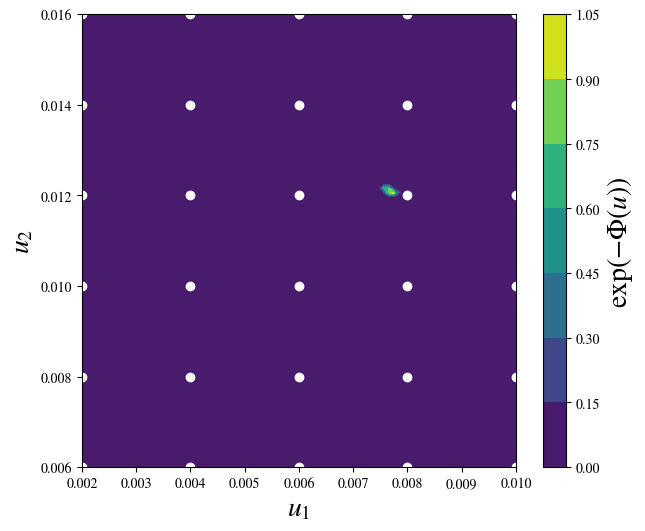

In [95]:
train_path1 = "./data/trainGrid1102.mat"
test_path = "./data/testGrid1102.mat"

U_scaler1, Y_scaler1, GP1 = GPRPredictor(train_path1, test_path, test_idx = 3, si_eta = 0.1)

# Second iteration

True value of $(u_1, u_2)$:  [0.007 0.013]
Maximum likelihood estimate of $(u_1, u_2)$:  [0.0069899 0.0130101]


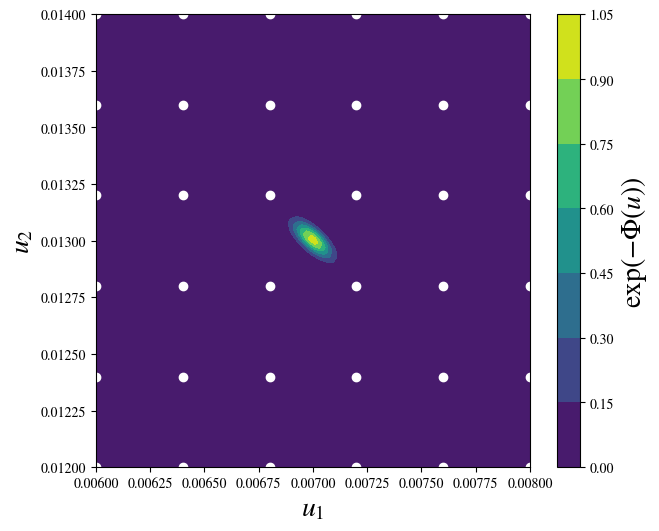

In [96]:
train_path2 = "./data/trainGrid1102_1.mat"
test_path = "./data/testGrid1102.mat"

U_scaler2, Y_scaler2, GP2 = GPRPredictor(train_path2, test_path, test_idx = 3, si_eta = 0.1)

# Load training and testing data

In [89]:
# Load training data set

loaded = sio.loadmat("./data/trainGrid1102.mat")
U = loaded['Us']
Y = loaded['observations']


U_scaler = preprocessing.StandardScaler()
U_scaler.fit(U)
U_scaled = U_scaler.transform(U)

Y_scaler = preprocessing.StandardScaler()
Y_scaler.fit(Y)
Y_scaled = Y_scaler.transform(Y)

# Load testing data set
loaded = sio.loadmat("./data/testGrid1102.mat")
U_test = loaded['Us']
Y_test = loaded['observations']

U_test_scaled = U_scaler.transform(U_test)
Y_test_scaled = Y_scaler.transform(Y_test)

In [90]:
# Train the gaussian_process
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(U_scaled, Y_scaled)
gaussian_process.kernel_

0.995**2 * RBF(length_scale=0.311)

In [91]:
# Calculate U_plot
minU = np.min(U, axis = 0)
maxU = np.max(U, axis = 0)
nOfGridPoints = 100

xis = []
for i in range(minU.shape[0]):
    xis.append(np.linspace(minU[i], maxU[i], nOfGridPoints))

# Generate grid and draw predictions
UPlotGrid = np.meshgrid(xis[0], xis[1])
UPlotGrid = np.stack(UPlotGrid, axis = 2)
UPlotGridFat = UPlotGrid.reshape([nOfGridPoints * nOfGridPoints, maxU.shape[0]])
UPlotGridFat_scaled = U_scaler.transform(UPlotGridFat)
YPlotGridFat_scaled = gaussian_process.predict(UPlotGridFat_scaled)
YPlotGrid_scaled = YPlotGridFat_scaled.reshape([nOfGridPoints, nOfGridPoints, Y_scaled.shape[1]])


# Plot the predicted distribution for a test data point

True value of $(u_1, u_2)$:  [0.007 0.013]
Maximum likelihood estimate of $(u_1, u_2)$:  [0.0079798 0.0119596]


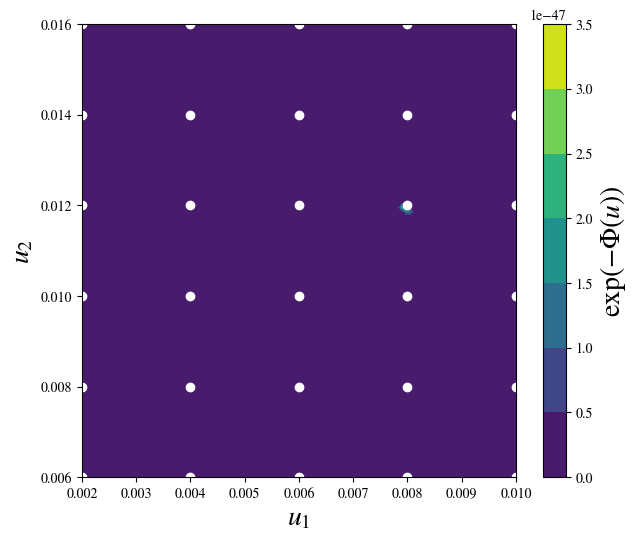

In [92]:
# Test
test_idx = 3
u = U_test_scaled[test_idx, :]
y = Y_test_scaled[test_idx, :]
si_eta = 0.1

# Compute \Phi(u) = \|y - G_N(u)\|^2
PhiPlot_grid = np.linalg.norm(y - YPlotGrid_scaled, axis = 2) ** 2

# Compute pdf(u) = exp(-\Phi(u))
pdf_grid = np.exp(-PhiPlot_grid / si_eta)

# Plot figure
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.ticker import LinearLocator
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, ax = plt.subplots(1, 1, figsize = (7, 6), dpi = 100)

# Plot the surface.
# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

cp = ax.contourf(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid)

# surf = ax.plot_surface(UPlotGrid[:, :, 0], UPlotGrid[:, :, 1], pdf_grid, rstride=1, cstride=1, cmap=cm.hsv, \
#   edgecolor='darkred', linewidth=0.1)
cbar = fig.colorbar(cp)
ax.scatter(U[:, 0], U[:, 1], color='white')
ax.set_xlabel('$u_1$', fontsize = 20)
ax.set_ylabel('$u_2$', fontsize = 20)
cbar.set_label('$\exp(-\\Phi(u))$', fontsize = 20)
# ax.set_zlabel('Unnormalized $d\mu(u)$', fontsize = 20)

# plt.scatter(U.reshape([-1]), np.linalg.norm(y - Y, axis = 1) ** 2)

# # Customize z axis
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
ind = np.unravel_index(np.argmax(pdf_grid, axis=None), pdf_grid.shape)
print("True value of $(u_1, u_2)$: ", U_scaler.inverse_transform(u.reshape([1, -1])).reshape(-1))
print("Maximum likelihood estimate of $(u_1, u_2)$: ", UPlotGrid[ind])

plt.show()

In [42]:
UPlotGrid[ind]

array([0.00361616, 0.01357576])